In [77]:
#PLEASE RUN THIS CELL TWICE, THE FIGSIZE CALL NEVER WORKS FIRST TIME
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7]
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

In [14]:
from scipy.spatial.distance import pdist, squareform
def VAT(R):
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)
    
    I = i[j]
    del J[I]
    
    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    C = [1,1]

    for r in range(2, N-1):
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)
        y = np.min(y)
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])

    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)

    I.extend(J)
    C.extend(i)

    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    return RV.tolist(), C, I


def entropy(probs):
    
    return -probs.dot(np.log2(probs))


#CHANGES MADE
def mutual_info(df):
    
    probsX=df.iloc[:,0].value_counts(normalize=True, sort=True)
    probsY=df.iloc[:,1].value_counts(normalize=True, sort=True)
    # Added a measure to replace 0 values with 1, so that the entropy calculations produce
    # zero for these values, rather than nan
    EPS = 1.0e-6
    probsX=probsX.where(probsX>EPS,1)
    probsY=probsY.where(probsY>EPS,1)
    
    Hx = entropy(probsX)
    Hy = entropy(probsY)
    
    counts = df.groupby(list(df.columns.values)).size()
    probs = counts/ counts.values.sum()
    H_xy = entropy(probs)

    # Mutual Information
    I_xy = Hx + Hy - H_xy
    MI = I_xy
    NMI = I_xy/min(Hx,Hy) #I_xy/np.sqrt(H_x*H_y)
    
    return {'H_'+list(df)[0]:Hx,'H_'+list(df)[1]:Hy,'MI':MI,'NMI':NMI} 


In [15]:
food =  pd.read_csv("food_nutrient_2011_13_AHS.csv", header=0,low_memory=False)

In [16]:
##Question 1


###1a
food_attributes=food.loc[:,'Energy, with dietary fibre (kJ)':].astype('float').copy()
###1b
scaler=StandardScaler()
foodscaled=scaler.fit_transform(food_attributes)

###1c
print("***")
print("Q1.c: foodscaled matrix details")
print("Number of rows:",foodscaled.shape[0])
print("Number of columns:",foodscaled.shape[1])
print("Min:",round(foodscaled.min(),1))
print("Max:",round(foodscaled.max(),1))
print("Mean:", round(foodscaled.mean(),1))
print("Standard Deviation:",foodscaled.std())
print("***")

***
Q1.c: foodscaled matrix details
Number of rows: 5740
Number of columns: 53
Min: -2.0
Max: 75.8
Mean: 0.0
Standard Deviation: 1.0
***


Variance explained by each PC [0.13310201 0.11808766]


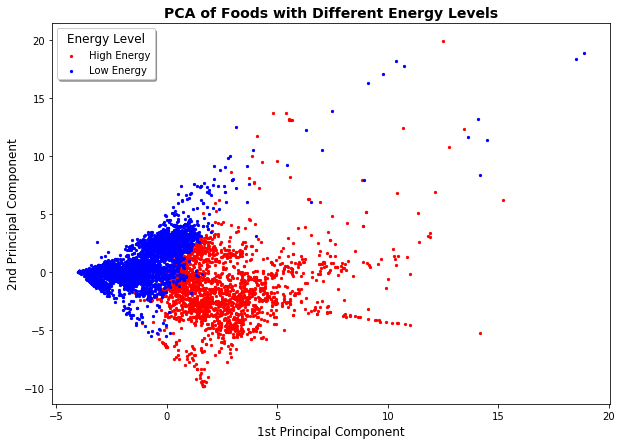

In [17]:
#Question 2


###2a
EnergyLevel = np.where(food['Energy, with dietary fibre (kJ)']>1000, 1, 0)
food['EnergyLevel']=EnergyLevel
EnergyHigh = food.loc[food['EnergyLevel']==1].index
EnergyLow = food.loc[food['EnergyLevel']==0].index

###2b
pca=PCA(n_components=2)
foodreduced=pca.fit_transform(foodscaled)
#not necessary but nice
print("Variance explained by each PC",pca.explained_variance_ratio_) 
###2c
plt.scatter(foodreduced[EnergyHigh,0],foodreduced[EnergyHigh,1],c='red',
            s=5,label='High Energy')
plt.scatter(foodreduced[EnergyLow,0],foodreduced[EnergyLow,1],c='blue',
            s=5,label='Low Energy')
plt.xlabel('1st Principal Component', size=12)
plt.ylabel('2nd Principal Component', size=12)
plt.legend(loc='upper left',shadow=True,title="Energy Level",
           title_fontsize=12)
plt.title("PCA of Foods with Different Energy Levels",weight="bold",size=14)
plt.show()

Question 2d:

At very least, this shows that our data can be seperated into 2 seperate clusters, High Energy and Low Energy foods, using their first two principle components. This can be seen quite clearly, as most of the High Energy foods are seperate from the Low Energy foods, with very little overlapping. High Energy foods are on average, larger in the first principle component whilst both are evenly distributed about the second. There is also possibly more High Energy foods, than Low Energy foods from first glace. Low Energy foods are more clustered together, whilst High Energy foods are spread out a bit more.

This can be interpretted as High Energy foods potentially having a larger variety of nutrients in their composition on average, but in general have a different nutrient composition and that there is more variance among High Energy foods in general. A larger variety could mean that these foods are more dense or nutrient packed per unit weight than Low Energy foods.

Given that each of the 53 attributes of the original data frame refer to a different nutrient, it is hard to find 2 components that contribute to a large percentage of the total variance; the data itself does not have all it's variance along any single attribute, but rather it is shared more equally amongst all attributes. This makes it difficult to pin down what each of the principle components are referring to exactly, and harder to make definitive meaningful interpretations from the results. However, PCA is a great tool to get some idea of the differences between groups, whether the data is seperable, and make ANY interpretations of the large data set which would otherwise be overwhelming and impossible to conceptualise as a whole.


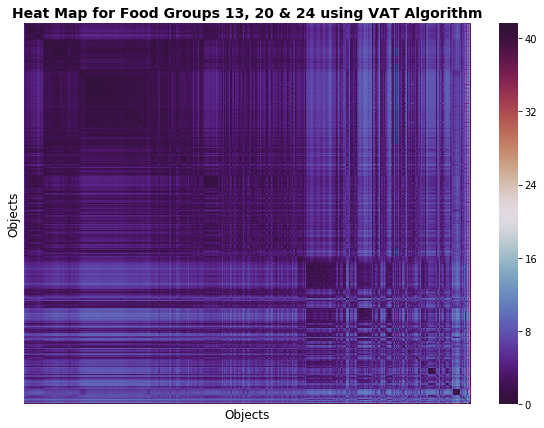

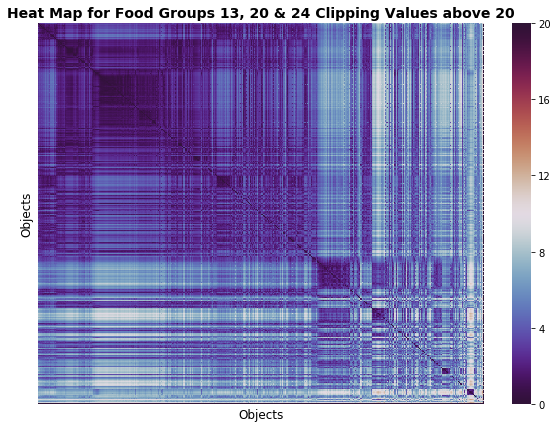

In [18]:
#Question 3


###3a
food['Survey ID']=food['Survey ID'].astype('str')
food['Food category']=food['Survey ID'].str[0:2] 
food['Food category']=food['Food category'].astype('int')

###3b
#creating an idex that corresponds only to foods in the specified groups.
food13=food.loc[food['Food category']==13].index.tolist()
food20=food.loc[food['Food category']==20].index.tolist()
food24=food.loc[food['Food category']==24].index.tolist()
foodsampleindex=food13+food20+food24

foodscaledsample=foodscaled[foodsampleindex,:]
###3c
RV, C, I = VAT(foodscaledsample)


###3d
x=sns.heatmap(RV,cmap='twilight_shifted',xticklabels=False,yticklabels=False)
plt.xlabel('Objects',size=12)
plt.ylabel('Objects',size=12)
plt.title('Heat Map for Food Groups 13, 20 & 24 using VAT Algorithm',weight='bold',size=14)
plt.show()

#We can see that most of the data is in the 0-24 range, thus clipping the data better 
#visualises the clusters

x=sns.heatmap(RV,cmap='twilight_shifted',vmax=20,xticklabels=False,yticklabels=False)
plt.xlabel('Objects',size=12)
plt.ylabel('Objects',size=12)
plt.title('Heat Map for Food Groups 13, 20 & 24 Clipping Values above 20',weight='bold',size=14)
plt.show()

Question 3e:

There are 2 main clusters in this heatmap. This is somewhat expected. The data sample used was comprised of 3 different food groups, thus, it could be argued that we would expect to obtain 3 seperate clusters for each food group. Although, we know every food group can be seperated into High and Low energy foods, and thus maybe this is what is represented. Also, perhaps two food groups (likely 20 & 24) are similar and together comprise the first and larger cluster in the top left, as we can see two smaller clusters within that large cluster.

The use of different colourmaps alters how visible the clusters are depending entirely on the data. It seems that most of our data has values in the 0-24 range (ie, the "blue" part of the colormap), and thus choosing a colourmap that changes colours rapidly in the early range will help to visualise the clusters. However, this is specific to our dataset. Alternatively, clipping the upper end of our data (as shown in the second heatmap) helps as the majority of the data now changes colours more rapidly. For this task, choosing a colour map that changes gradient quickly in the early ranges (or overall) helps to visualise the clusters.


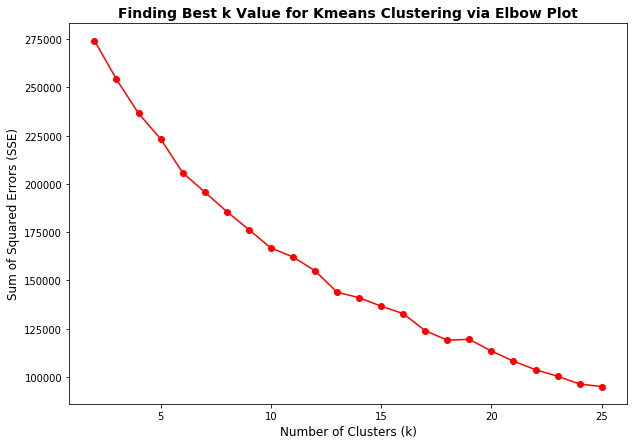

In [19]:
#Question 4

###4a 
sse={}
for k in range(2,26):
    kmeans = KMeans(n_clusters=k, random_state=100).fit(foodscaled)
    #inbuilt function for sum of squared errors
    sse[k]=kmeans.inertia_
plt.plot(list(sse.keys()),list(sse.values()),'ro',linestyle='-')
plt.xlabel("Number of Clusters (k)",size=12)
plt.ylabel("Sum of Squared Errors (SSE)",size=12)
plt.title("Finding Best k Value for Kmeans Clustering via Elbow Plot",weight="bold",size=14)
plt.show()


Question 4b:
The shape of the plot is hyperbolic (not quite negative linear) with a negative trend. This is to say that as the number of clusters increases, the sum of the squared errors for each point to their nearest cluster centre decreases. This is to be expected, as it is inherently a property of Kmeans clustering and SSE.

We hope to be able to see a clear elbow in the data (in the bottom left corner), signifying a cluster value that gives a low sum of squared error without such a high number of clusters, however in our case the elbow isn't very clear or obvious, lying somewhere in the 7-13 range. For the purpose of choosing a single value, I would chose 14, due to it's relatively steep gradient in the elbow region.

This result is somewhat expected, since we are trying to cluster food data from approximately 30 different food groups, many of these food groups overlapping in nutritional information and composition. With so many food groups, and even accounting for overlaps or similar groups, a cluster value around 10 seems a bit unlikely, whilst 25 or higher seems much more appropriate, but less useful.


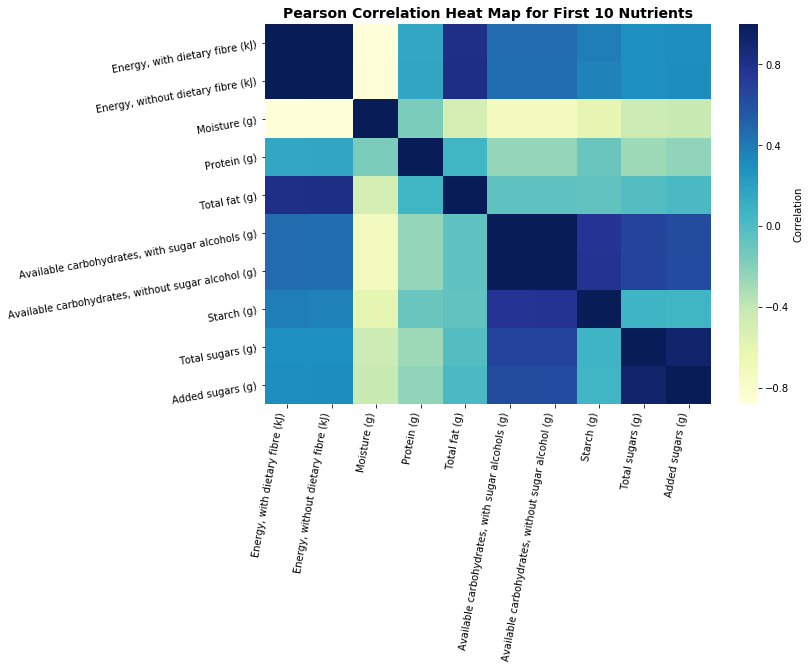

In [49]:
###Question 5
###5a
first10=food.loc[:,'Energy, with dietary fibre (kJ)':'Added sugars (g)'].copy()
labels=list(first10)
corrmatrix=np.zeros((10,10))
for col1 in range (0,10):
    for col2 in range (0,10):
        corrmatrix[col1,col2]=first10.iloc[:,col1].corr(first10.iloc[:,col2])

x=sns.heatmap(corrmatrix,cmap='YlGnBu',xticklabels=True,yticklabels=True,cbar_kws={"label":"Correlation"})
locs,label=plt.yticks()
plt.yticks(locs,labels=labels,rotation=10,size=10)
locs,label=plt.xticks()
plt.xticks(locs,labels=labels,rotation=80,size=10,horizontalalignment='right')
#plt.xlabel('First 10 Nutrients',size=12,weight='bold')
#plt.ylabel('First 10 Nutrients',size=12,position=(0,0.53),rotation=0,weight='bold')
plt.title('Pearson Correlation Heat Map for First 10 Nutrients',weight='bold',size=14)
plt.show()
        

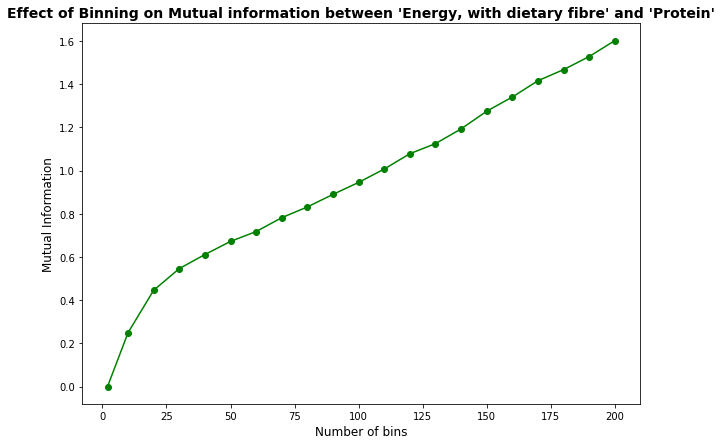

In [50]:
###5b code
EnergyAndPro=food.loc[:,['Energy, with dietary fibre (kJ)','Protein (g)']]
binned=EnergyAndPro
MI={}
binrange=np.append(2,range(10,210,10))
#loop to generate MI value for different bin numbers. EnergyAndPro DF must be regenerated
#each time since pd.cut() alters it at each call.
for bins in binrange:
    EnergyAndPro=food.loc[:,['Energy, with dietary fibre (kJ)','Protein (g)']]
    EnergyIndex=EnergyAndPro.iloc[:,0].value_counts(normalize=True, sort=True,bins=bins).index
    ProteinIndex=EnergyAndPro.iloc[:,1].value_counts(normalize=True, sort=True,bins=bins).index
    binned['Energy, with dietary fibre (kJ)']=pd.Series(pd.cut(EnergyAndPro['Energy, with dietary fibre (kJ)'],EnergyIndex))
    binned['Protein (g)']=pd.Series(pd.cut(EnergyAndPro['Protein (g)'],ProteinIndex))
    MI[bins]=mutual_info(binned)['MI']
    
plt.plot(list(MI.keys()),list(MI.values()),'go',linestyle='-')
plt.xlabel("Number of Bins",size=12)
plt.ylabel("Mutual Information",size=12)
plt.title("Effect of Binning on Mutual information between 'Energy, with dietary fibre' and 'Protein'"
          ,weight="bold",size=14)
plt.show()




Question 5b comment

The plot above has something of a square root shape at first but then becomes linear, with a positive trend. As the number of equal-width bins increases, the Mutual Information between 'Energy, with dietary fibre' and 'Protein' increases, but the rate at which it increases is intiailly much greater, meaning there is a greater difference in MI between the lower bin values (2-25). Overall, as we increasingly seperate our these two attributes into discrete bins, we gain more information about the other variable as a result.

In [22]:
###5c code
#top-10 attribute pairs by Pearson Correlation. For loop that goes through every possible 
#pair combination of attributes, and finds the correlation between each, storing these in a
#dictionary that is then converted to a Series for more functionality. # TAKES AGES BEWARE
numattributes=food_attributes.shape[1]
corrdict={}
for col1 in range (0,numattributes):
    for col2 in range (col1+1,numattributes):
        value='{} & {}'.format(food_attributes.columns[col1],food_attributes.columns[col2])
        #take absolute value since pearson correlation strength is independent of sign
        corrdict[value]=abs(food_attributes.iloc[:,col1].corr(food_attributes.iloc[:,col2]))
pearson=pd.Series(corrdict)

#top-10 attribute pairs by Mutual Information. Same idea as above, except obviously with
#the provided mutual information function. 
numattributes=food_attributes.shape[1]
attribute_pair=food_attributes.iloc[:,[0,1]]
binned=attribute_pair
MIdict={}
for col1 in range (0,numattributes):
    for col2 in range (col1+1,numattributes):
        attribute_pair=food_attributes.iloc[:,[col1,col2]].copy()
        name1=attribute_pair.columns[0]
        name2=attribute_pair.columns[1]
        binned=attribute_pair
        Index1=attribute_pair.iloc[:,0].value_counts(normalize=True, sort=True,bins=20).index
        Index2=attribute_pair.iloc[:,1].value_counts(normalize=True, sort=True,bins=20).index
        binned[name1]=pd.Series(pd.cut(attribute_pair[name1],Index1))
        binned[name2]=pd.Series(pd.cut(attribute_pair[name2],Index2))
        value='{} & {}'.format(name1,name2)
        MIdict[value]=mutual_info(binned)['MI']

mutualinfo=pd.Series(MIdict)
#Printed out in the next cell

In [23]:
print("Top 10 by Pearson Correlation:")
print(pearson.nlargest(10))
print("******************************************************************")
print("\n")
print("Top 10 by Mutual Information:")
print(mutualinfo.nlargest(10))

Top 10 by Pearson Correlation:
Alpha-tocopherol (mg) & Vitamin E (mg)                                                                   0.999528
Energy, with dietary fibre (kJ) & Energy, without dietary fibre (kJ)                                     0.998608
Beta-carotene (µg) & Provitamin A (b-carotene equivalents) (µg)                                          0.995961
Available carbohydrates, with sugar alcohols (g) & Available carbohydrates, without sugar alcohol (g)    0.995466
Added sugars (g) & Free sugars (g)                                                                       0.988894
Total Folates  (µg) & Dietary folate equivalents  (µg)                                                   0.985763
Total polyunsaturated fat (g) & Linoleic acid (g)                                                        0.973640
Folic acid  (µg) & Dietary folate equivalents  (µg)                                                      0.958112
Preformed vitamin A (retinol) (µg) & Vitamin A retinol eq

Question 5c comment:
We can see that some of the relationships found by Pearson Correlation, are also found by Mutual information to some degree, in fact exactly 3 values exist in both lists. However, mutual information finds additional relationships that are (presumably) non-linear, as that is the disadvantage of Pearson Correlation; it only finds linear relationships.  Thus, we can intepret these results as Mutual information finding strong relationships that are non-linear, as well as the strong linear relationships.

***
Q6.a: Train Test Split Results
X_train matrix: (4592, 53)
y_train labels: (4592,)
X_test matrix: (1148, 53)
y_test labels: (1148,)
***


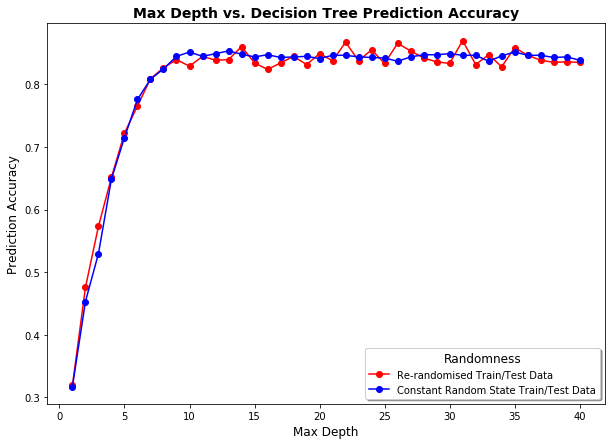

In [75]:
##Question 6
###6a
y=food['Food category']
X_train,X_test,y_train,y_test=train_test_split(foodscaled,y,test_size=0.2,random_state=42)
print("***")
print("Q6.a: Train Test Split Results")
print("X_train matrix:",X_train.shape)
print("y_train labels:",y_train.shape)
print("X_test matrix:",X_test.shape)
print("y_test labels:",y_test.shape)
print("***")
###6b

#Creating two different accuracy dictionaries, one where the training and test
#split data is constant, the other where the split is given a different random seed
#for each iteration of the loop. ie, increasing "randomness".
accuracy={}
for depth in range(1,41):
    dt = DecisionTreeClassifier(criterion="entropy",random_state=depth, max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred=dt.predict(X_test)
    accuracy[depth]=accuracy_score(y_test, y_pred)

accuracy2={}
for depth in range(1,41):
    X_train,X_test,y_train,y_test=train_test_split(foodscaled,y,test_size=0.2,random_state=depth)
    dt = DecisionTreeClassifier(criterion="entropy",random_state=depth, max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred=dt.predict(X_test)
    accuracy2[depth]=accuracy_score(y_test, y_pred)

#plotting the two results to compare the effect of increasing the randomness of the data
plt.plot(list(accuracy2.keys()),list(accuracy2.values()),'ro',linestyle='-',label="Re-randomised Train/Test Data")
plt.plot(list(accuracy.keys()),list(accuracy.values()),'bo',linestyle='-', label="Constant Random State Train/Test Data")
plt.xlabel("Max Depth",size=12)
plt.ylabel("Prediction Accuracy",size=12)
plt.legend(loc='lower right',shadow=True,title="Randomness",
           title_fontsize=12)
plt.title("Max Depth vs. Decision Tree Prediction Accuracy"
          ,weight="bold",size=14)
plt.show()

In [28]:
print("Max Accuracy for Constant Random State Data occurs when Depth is:",max(accuracy, key=accuracy.get))
print("Max Accuracy for Re-randomised Data occurs when Depth is:",max(accuracy2, key=accuracy2.get))

Max Accuracy for Constant Random State Data occurs when Depth is: 13
Max Accuracy for Re-randomised Data occurs when Depth is: 31


Question 6c:
This question can be done in a variety of ways, producing slightly different results
each time, depening on how random the generations of the data are each time. For example,
if in each iteration of the loop, we re-generate our test/train data, with a different random
state, and then the decision tree classifier with a different random state also, then the maximum accuracy value changes. However, the general shape and behaviour of the plot remainds the same.

This can be seen from the graph, as in both cases, the trend of the data after an enforced max depth of 10 is close to a constant, neither gaining or losing prediction accuracy.

Therefore, any peaks arising in the Re-randomised data can be attributed to the particular random seed of that data split. Overall, a max depth of 10 for a decision tree classifier is sufficient to classify the data at a high accuracy.

Additionally, the maximum depth value is not enforced, it is just an 'allowance' for the trees' depth. The tree will stop creating deeper nodes once the threshold entropy value has been met and a leaf is considered 'pure'. Thus, increasing max depth beyond 10 may actually be overfitting the data, or very little changes are made at all due to the depth 'allowance' not being used.

In [60]:
#Question 7

###7a
y=food['Food category']
#note, the split can be done using the unstandardised food_attributes DF, with lower accuracy
#results, see comment 7d
X_train,X_test,y_train,y_test=train_test_split(foodscaled,y,test_size=0.2,random_state=42)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
train_pred=knn.predict(X_train)
test_pred=knn.predict(X_test)

print("***")
print("Q7a: Food category prediction using k-NN (k=1)")
print("Train accuracy:",round(100*accuracy_score(y_train, train_pred),1),"%")
print("Test accuracy:",round(100*accuracy_score(y_test, test_pred),1),"%")
print("***")

print("\n")
##7b
X_train,X_test,y_train,y_test=train_test_split(foodscaled,y,test_size=0.2,random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
train_pred=knn.predict(X_train)
test_pred=knn.predict(X_test)

print("***")
print("Q7.b: Food category prediction using k-NN (k=3)")
print("Train accuracy:",round(100*accuracy_score(y_train, train_pred),1),"%")
print("Test accuracy:",round(100*accuracy_score(y_test, test_pred),1),"%")
print("***")


***
Q7a: Food category prediction using k-NN (k=1)
Train accuracy: 100.0 %
Test accuracy: 89.5 %
***


***
Q7.b: Food category prediction using k-NN (k=3)
Train accuracy: 93.3 %
Test accuracy: 88.0 %
***


Question 7c comment:
The results from 7a and 7b differ.
TRAIN:
Due to the way that k-NN classification works, when we take the 1st closest neighbour (k=1), and use this on the Train data (the data we used to initialise the k-NN classification model), we know we will achieve an accuracy of 1.0, as the closest neighbour to every point in the data will be the points themselves, and thus it will be assigned its original food category. However, when k=3, the nearest point will be itself, and 2 others. If those 2 other points have different food categories (which seems to have happend 6.7% of the time), the food category will be different to the correct one. 

TEST:
In regards to the Test data, it may be the case that a k value of 3 is too large, and we start to include points from other classes in some of our neighbourhoods, reducing the overall accuracy, however the accuracies dont differ much. Larger k values may increase the accuracy again.

Question 7d comment:

Because our data in foodscaled has been standardised to 0 mean and unit variance, the euclidean distance calculations (used to find the nearest neighbour of each point) will produce small values, resulting in high accuracies. If we used Pearson correlation, or unstandardised values before using k-NN classification, we may find a more realistic result. (ie, passing food_attributes DF, rather than foodscaled to this question produces lower accuracies)


In [65]:
#FUNCTION FOR FEATURE GENERATION AND SELECTION
#function takes 2 arguements (explained below). Variables that remain constant are:
#Clustering_label feature - always generated with Kmeans, n_clusters=14 (from Q4)
#Number of bins for mutual information - always 20.
#Number of k-nearest neighbours - always 3 to compare with question 7 results.
#THIS CELL TAKES AGES, AND I SWEAR MY COMPUTER ALMOST FRIED ITSELF

def featuregenselect(k,n):
    #2k = number of generated interaction term features, k (f*f) interaction term features,
    #     and k (f/f) interaction term features
    #n = The size of the subset of features to be selected, from the total number N

    #First, we split our data into train and test. Note we are using the unscaled data! 
    #This is because Mutual information seems to break down when data is scaled and 
    #includes negatives.
    classlabels=food['Food category'].copy()
    X_train,X_test,y_train,y_test=train_test_split(food_attributes.copy(),classlabels,test_size=0.2,random_state=42)

    #FEATURE GENERATION

    #Clustering Labels
    #Use kmeans with n=14 (see Question 4 discussion), to generate clusters for each instance
    #in Train data, and then assign each instance in Test data to its nearest cluster.
    kmeans = KMeans(n_clusters=14, random_state=100).fit(X_train)
    clusterlabels=kmeans.labels_
    X_train['Cluster_Labels']=clusterlabels
    X_test['Cluster_Labels']=kmeans.predict(X_test)

    #Interaction Term Pairs
    #Here, I am randomly generating k column numbers into 2 different arrays, and then 
    #either multiplying or dividing the corresponding column numbers to create k new features
    import random
    import math
    firstcols=np.array(random.sample(range(0, 53), k))
    secondcols=np.array(random.sample(range(0,53), k))
    #loop that generates Interaction term pairs, both divisors and multipliers.
    for i in range(0,k):
        f1=firstcols[i]
        f3=firstcols[k-(i+1)]
        f2=secondcols[i]
        value='f({})/f({})'.format(f1,f2)
        X_train[value]=X_train[X_train.columns[f1]].copy()/X_train[X_train.columns[f2]].copy()
        X_test[value]=X_test[X_test.columns[f1]].copy()/X_test[X_test.columns[f2]].copy()
    
        #replacing inf values with NaN so that they can be replaced by 0's.
        X_test[value]=X_test[value].where(np.isfinite(X_test[value]),np.nan)
        X_test[value]=X_test[value].fillna(0)
        X_train[value]=X_train[value].where(np.isfinite(X_train[value]),np.nan)
        X_train[value]=X_train[value].fillna(0)
    
        value2='f({})*f({})'.format(f3,f2)
        X_train[value2]=X_train[X_train.columns[f3]].copy()*X_train[X_train.columns[f2]].copy()
        X_test[value2]=X_test[X_test.columns[f3]].copy()*X_test[X_test.columns[f2]].copy()

    #Rounding everything to 2 decimal places, to match the exisiting form of entries.
    X_train=X_train.round(2)
    X_test=X_test.round(2)

    #FEATURE SELECTION
    #Computing MI between all features (new and old) and the Class label (ie Food Category),
    #and then sampling the top n by this value
    numattributes=X_train.shape[1]
    #added classlabels to the data frame for ease of computation in the loop.
    X_train['classlabels']=y_train
    MIdict={}
    for col in range (0,numattributes):
        #In this case, the (numattributes)th column is the classlabel, which does'nt need to
        #be binned due to its already finite range (0-31, from assignment 1)
        attribute_pair=X_train.iloc[:,[col,numattributes]].copy()
        name1=attribute_pair.columns[0]
        binned=attribute_pair
        Index1=attribute_pair.iloc[:,0].value_counts(normalize=True, sort=True,bins=20).index
        binned[name1]=pd.Series(pd.cut(attribute_pair[name1],Index1))
        value='{}'.format(name1)
        MIdict[value]=mutual_info(binned)['MI']

    #Converting Generated Dictionary of MI values to Series, for ease of selecting the top n
    MIDF=pd.Series(MIdict)
    topnfeatures=MIDF.nlargest(n).index.tolist()

    #Slicing Train data by the top n features by MI value, assigning to new DF
    X_train_topn=X_train.loc[:,topnfeatures].astype('float').copy()
    X_test_topn=X_test.loc[:,topnfeatures].astype('float').copy()

    #Rescaling our new DF with a subset n<N features, to compare with Question 7 results
    scaler=StandardScaler()
    X_train_topn=scaler.fit_transform(X_train_topn)
    X_test_topn=scaler.fit_transform(X_test_topn)

    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train_topn, y_train)
    train_pred=knn.predict(X_train_topn)
    test_pred=knn.predict(X_test_topn)
    
    return {"Train_accuracy":round(100*accuracy_score(y_train, train_pred),1),
            "Test_accuracy":round(100*accuracy_score(y_test, test_pred),1)}

#Using the above defined function, we can investigate the effect of varying both k
#(half the number of generated features) and n, the subset of selected features by MI value.

#Varying k, and leaving n constant at 25:
kvariation_train={}
kvariation_test={}
for i in range(0,10):
    kvariation_train[2*i]=featuregenselect(i,25)['Train_accuracy']
    kvariation_test[2*i]=featuregenselect(i,25)['Test_accuracy']



In [68]:
#Can see from plot above, that a decent number of generated values is 12 (k=6)
nvariation_train={}
nvariation_test={}
for i in range(10,55,4):
    nvariation_train[i]=featuregenselect(5,i)['Train_accuracy']
    nvariation_test[i]=featuregenselect(5,i)['Test_accuracy']


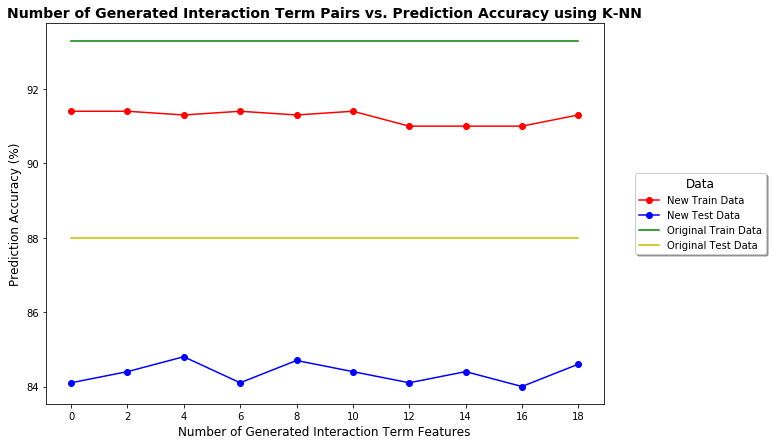

In [73]:
#PLOTTING RESULTS

plt.plot(list(kvariation_train.keys()),list(kvariation_train.values()),'ro-',label="New Train Data")
plt.plot(list(kvariation_test.keys()),list(kvariation_test.values()),'bo-', label="New Test Data")
plt.plot([0,2,4,6,8,10,12,14,16,18],np.full((10,1),93.3),'g-',label='Original Train Data')
plt.plot([0,2,4,6,8,10,12,14,16,18],np.full((10,1),88.0),'y-',label='Original Test Data')
plt.xlabel("Number of Generated Interaction Term Features",size=12)
plt.ylabel("Prediction Accuracy (%)",size=12)
plt.xticks([0,2,4,6,8,10,12,14,16,18],[0,2,4,6,8,10,12,14,16,18])
plt.legend(loc='center right',shadow=True,title="Data",
           title_fontsize=12,bbox_to_anchor=(1.3,0.5))
plt.title("Number of Generated Interaction Term Pairs vs. Prediction Accuracy using K-NN"
          ,weight="bold",size=14)
plt.show()

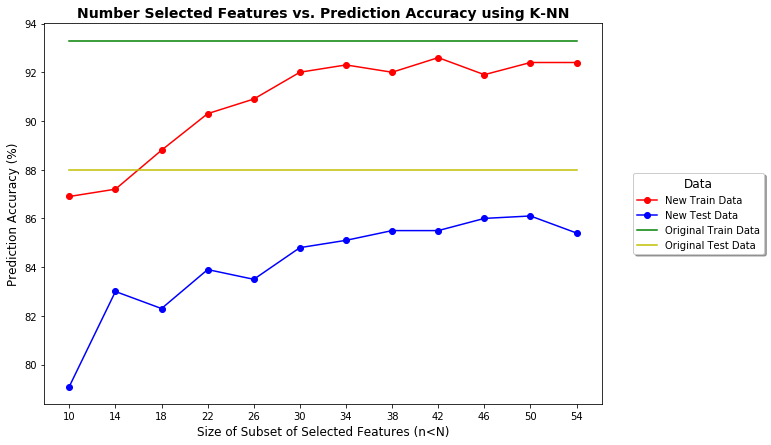

In [74]:
plt.plot(list(nvariation_train.keys()),list(nvariation_train.values()),'ro',linestyle='-',label="New Train Data")
plt.plot(list(nvariation_test.keys()),list(nvariation_test.values()),'bo',linestyle='-', label="New Test Data")
plt.plot([10,14,18,22,26,30,34,38,42,46,50,54],np.full((12,1),93.3),'g-',label='Original Train Data')
plt.plot([10,14,18,22,26,30,34,38,42,46,50,54],np.full((12,1),88.0),'y-',label='Original Test Data')
plt.xlabel("Size of Subset of Selected Features (n<N)",size=12)
plt.ylabel("Prediction Accuracy (%)",size=12)
plt.xticks([10,14,18,22,26,30,34,38,42,46,50,54],[10,14,18,22,26,30,34,38,42,46,50,54])
plt.legend(loc='center right',shadow=True,title="Data",
           title_fontsize=12,bbox_to_anchor=(1.3,0.5))
plt.title("Number Selected Features vs. Prediction Accuracy using K-NN"
          ,weight="bold",size=14)
plt.show()

Question 8 comment:

Based on the graphs above we can make a few observations. Firstly, the overall prediction accuracy does not seem to increase with the number of generated features in general, or atleast when we select the top 25 features by MI as a subset. This may be due to the selection of features used to create new interaction term features. Since this process is random, sometimes the generated features will useful, other times they may not be. However, some of the generated features definitely do occur in the list of the nlargest by mutual information (print topnfeatures to verify).

However, the size of the subset of selected features (n<N) does have a large impact on overall prediction accuracy, especially at the lower end. We can clearly see a positive relationship between accuracy and subset size at the beginning, but as we increase the subset size further it seems to produce a negative relationship. Thus, the overall trend appears to be negative quadratic. At the lower end we can see a local peak, possibly indicating that a slight change in the subset size may end up including more redundant features until it grows further.

Based on the results above, it is inconclusive as to whether or not the methods of feature generation and selection can provide a boost in prediction accuracy for this data. The methods implemented above only skim the surface of possible combinations and variations of variables involved in the feature generation and selection process. In my method, the only varied variables were the number of generated features, and the size of the subset of selected features. Other variables were left unchanged throughout that could've had an impact on the results, such as:

• Number of clusters used when generating Clustering Labels attribute - Always 14.
• Number of bins for mutual information - Always 20.
• Number of k-nearest neighbours - always 3 to compare with question 7 results.

Furthermore, the method implemented above for feature generation involved randomly selecting columns to be either divided, or multiplied together each time. This means that each time we execute the above cells, slightly different answers arise. Obviously, not all interaction term pair features will be the same, and some may have a strong Mutual Information relationship with the class labels, and should be generated every time we use this method, others may not contribute much at all, and should be ruled out. This would require further analysis and time.

A possible solution to the above would be to average the results across multiple runs of the above cells, or as stated, to keep track of strong interaction term pair combinations and use these continually. This would require a lot more processing power (as the above cells already take a long time to execute) and time. 

Finally, it should be mentioned that during the generation of interaction term pairs, specifically the division pairs (f1/f2), NaN and inf values arise. The method of dealing with such values is important (imputation), and will affect the overall results. I elected to replace all such values with 0, which is arguably a poor method of imputation. A better method would be to replace all NaN values with the mean of the column (attribute). Doing so may increase the mutual information strength of some of these pairs, and possibly overall prediction accuracy.

Overall, the results give an idea of some of the relationships, but are inconclusive, and it requires further investigation.

In [80]:
numattributes=food_attributes.shape[1]
corrdict={}
for col1 in range (0,numattributes):
    for col2 in range (col1+1,numattributes):
        value='{} & {}'.format(food_attributes.columns[col1],food_attributes.columns[col2])
        corrdict[value]=abs(food_attributes.iloc[:,col1].corr(food_attributes.iloc[:,col2]))
pearson=pd.Series(corrdict)
pearson.nlargest(10)

Alpha-tocopherol (mg) & Vitamin E (mg)                                                                   0.999528
Energy, with dietary fibre (kJ) & Energy, without dietary fibre (kJ)                                     0.998608
Beta-carotene (µg) & Provitamin A (b-carotene equivalents) (µg)                                          0.995961
Available carbohydrates, with sugar alcohols (g) & Available carbohydrates, without sugar alcohol (g)    0.995466
Added sugars (g) & Free sugars (g)                                                                       0.988894
Total Folates  (µg) & Dietary folate equivalents  (µg)                                                   0.985763
Total polyunsaturated fat (g) & Linoleic acid (g)                                                        0.973640
Folic acid  (µg) & Dietary folate equivalents  (µg)                                                      0.958112
Preformed vitamin A (retinol) (µg) & Vitamin A retinol equivalents (µg)                 